In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import io
import os
import zipfile
from PIL import Image
from matplotlib import pyplot as plt

Number of boundaries detected: 1


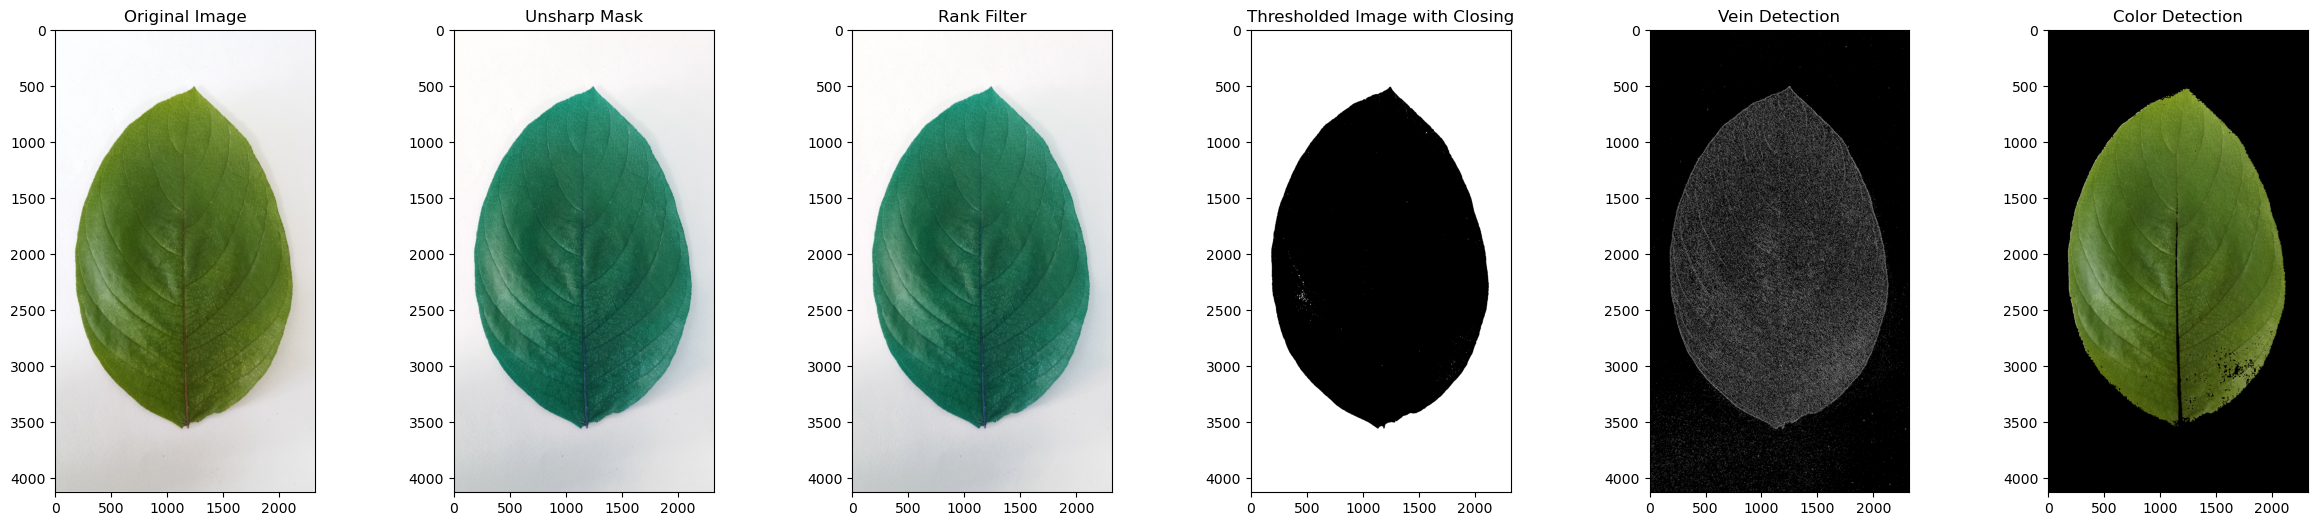

In [2]:
def detect_colors(image):
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the range of green color in HSV
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])
    
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # Bitwise-AND mask and original image
    result = cv2.bitwise_and(image, image, mask=mask)
    
    return result

def unsharp_mask(image, sigma=1.0, strength=2.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def rank_filter(image, ksize=3):
    return cv2.medianBlur(image, ksize)



zip_file_path = "D:/ezyZip.zip"

image_file_path = "Folio Leaf Dataset/Folio/"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_data = zip_ref.read(file_name)
            image = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
            # Display the image
            if image is not None:
                # Perform Unsharp Mask
                unsharp_image = unsharp_mask(image) 
                # Perform Rank Filter
                rank_filtered_image = rank_filter(unsharp_image)
                # Perform Gaussian blur
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                blurred_image = cv2.GaussianBlur(gray_image, (25,25), 0)
                # Perform adaptive thresholding using Otsu's method
                _, thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
                # Closing of holes using morphological transformation
                kernel = np.ones((5, 5), np.uint8)
                closing_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
                
                # Boundary extraction using contours
                contours, _ = cv2.findContours(closing_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                boundary_extracted_image = image
                cv2.drawContours(boundary_extracted_image, contours, -1, (255, 255, 255 ), 2)
                
                # Vein detection using edge detection
                edges = cv2.Sobel(gray_image, cv2.CV_8U, 1, 1, ksize=3)
                _, vein_image = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Print the number of contours found (which corresponds to the number of boundaries detected)
                print("Number of boundaries detected:", len(contours))
                
                # Color detection
                color_detection_result = detect_colors(image)
                
                # Display the original, thresholded, boundary-extracted images, and color detection result
                plt.figure(figsize=(30, 6))
                plt.subplot(1, 6, 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Original Image")
                plt.subplot(1, 6, 2)
                plt.imshow(unsharp_image, cmap='gray')
                plt.title("Unsharp Mask")
                plt.subplot(1, 6, 3)
                plt.imshow(rank_filtered_image, cmap='gray')
                plt.title("Rank Filter")
                plt.subplot(1, 6, 4)
                plt.imshow(closing_image, cmap='gray')
                plt.title("Thresholded Image with Closing") 
                plt.subplot(1, 6, 5)
                plt.imshow(vein_image, cmap='gray')
                plt.title("Vein Detection")
                plt.subplot(1, 6, 6)
                plt.imshow(cv2.cvtColor(color_detection_result, cv2.COLOR_BGR2RGB))
                plt.title("Color Detection")
                plt.show()
                break
                
            